"""
Copyright 2026 Zsolt Bedőházi

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

In [1]:
import sys
import os
import time
import random
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
from collections import Counter
from torch.utils.data import Dataset, DataLoader, Sampler, BatchSampler
from classic_mil import Feature_attention
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import auc as calc_auc
import matplotlib.pyplot as plt
import h5py
import json
from tqdm import tqdm

from omegaconf import OmegaConf

torch.set_num_threads(8)

In [2]:
CUDA_NUM = 1

In [3]:
conf_preproc = OmegaConf.load("../conf/preproc.yaml")
conf_train = OmegaConf.load("../conf/train.yaml")

conf_preproc = conf_preproc["project_mil"]
conf_train = conf_train["sote_finetuned_uni_224_224_patches_patients_rev_tuning"]

In [ ]:
conf_train.results_dir

In [ ]:
conf_train.cv_split_dir

### Functions and classes

In [6]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction="mean"):
        """
        :param gamma: focusing parameter
        :param alpha: balance parameter; can be float or list of per-class weights
        :param reduction: 'none' | 'mean' | 'sum'
        """
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha, (float, int)):  
            self.alpha = torch.tensor([alpha, 1 - alpha])  # binary case
        if isinstance(alpha, list):  
            self.alpha = torch.tensor(alpha)  # multiclass case
        self.reduction = reduction

    def forward(self, inputs, targets):
        """
        :param inputs: raw model outputs (logits) of shape [N, C]
        :param targets: ground truth labels of shape [N]
        """
        ce_loss = F.cross_entropy(inputs, targets, reduction="none", weight=self.alpha.to(inputs.device) if self.alpha is not None else None)
        pt = torch.exp(-ce_loss)  # pt = softmax probability of true class
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.reduction == "mean":
            return focal_loss.mean()
        elif self.reduction == "sum":
            return focal_loss.sum()
        else:
            return focal_loss

In [7]:
def create_biopsy_subset(labels, minority_class_ratio=1.0, sampling_exponent=0.5, rnd_seed=38):
    # set random seed as given
    np.random.seed(rnd_seed)
    
    # collect selected biopsies that will be in the balanced subset
    test_local_idx = []
    
    # get current class occurences for biopsy
    class_occurence = np.array(list(dict( Counter(labels) ).values()))[ np.argsort(list(dict( Counter(labels) ).keys()))]

    # calc class weights
    class_weights = ( np.power(class_occurence, sampling_exponent) / np.power(class_occurence, sampling_exponent).sum() ).astype(np.float32)
    
    class_weights_dict = dict( zip( np.arange(class_weights.shape[0]), class_weights ))
    nr_class_minority = min( int(labels.shape[0]*np.min(class_weights)), np.min(class_occurence) )*minority_class_ratio 
    nr_class_test = (nr_class_minority * (class_weights * 1/np.min(class_weights))).astype(int)
    class_counts = []
    
    # collect biopsy indices for the balanced subset
    for e, s in enumerate(np.unique(labels)): #loop over labelss
        s_idx = np.arange(labels.shape[0])[labels == s]
        rnd_idx = np.random.permutation(s_idx.shape[0])
        class_counts.append(len(s_idx[rnd_idx[:nr_class_test[e]]]))
        test_local_idx.append(s_idx[rnd_idx[:nr_class_test[e]]])
        
    class_counts = np.array(class_counts)
    
    # aggregate all the balanced subset's indices
    test_idx = np.concatenate(test_local_idx)
    
    random.Random(23).shuffle(test_idx) # shuffle otherwise lables are ordered
    
    # other indices not in balanced set will be the rest
    train_idx = np.arange(labels.shape[0])[~np.isin(np.arange(labels.shape[0]), test_idx)]

    
    return train_idx, test_idx#, label_remaining[]

In [8]:
def give_back_balanced_training_fold( X_current, y_current,
                                      minority_class_ratio=0.5, sampling_exponent=0.5, rnd_seed=12 ):
    
    # remove later
    # minority_class_ratio =1.0
    
    _, test_idx, = create_biopsy_subset(y_current,
                                                 minority_class_ratio,
                                                 sampling_exponent,
                                                 rnd_seed)
    
    X_train_balanced = X_current[test_idx]
    y_train_balanced = y_current[test_idx]
    #y_train_balanced_oh = lb.transform(y_train_balanced)
    #print( X_train_balanced.shape, y_train_balanced_oh.shape )
    
    return X_train_balanced, y_train_balanced

### Load all data

In [9]:
biopsy_embeddings_folder = conf_preproc.uni_finetuned_biopsy_dir_macenko_new_bracs
file_paths = np.array(sorted( [biopsy_embeddings_folder + i for i in os.listdir(biopsy_embeddings_folder) if '.h5' in i ]))
file_paths.shape

(286,)

In [10]:
class CollectionsDataset(Dataset):
    def __init__(self,
                 data,
                 labels,
                 num_classes, 
                 transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
        self.num_classes = num_classes

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)

        return image, np.expand_dims(label,0)

In [11]:
# not modified
def train_loop(cur, X_train_all, y_train_all, X_val_all, y_val_all, results_dir, num_epochs, model, n_classes, loss_fn=None, gc=32):  
            
    device=torch.device(f"cuda:{CUDA_NUM}" if torch.cuda.is_available() else "cpu") 
    
    print('\nInit optimizer ...', end=' ')
    
    if conf_train["use_scheduler"]:
        print("\nUsing lr scheduler...")
        optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=conf_train.initial_lr, weight_decay=conf_train.weight_decay)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=conf_train.eta_min)
        
    else:
        optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=conf_train.lr, weight_decay=conf_train.weight_decay)
    
    print('Done!')
    
    train_loss_all_epoch = []
    val_loss_all_epoch = []
    val_auc_all_epoch = []
    max_auc_epoch = 0.
    
    # training loop with balanced folds
    for epoch in range(0, num_epochs):
        #print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            
        ## TRAINING
        
        X_train, y_train = give_back_balanced_training_fold( X_train_all, y_train_all, 
                                                             minority_class_ratio=conf_train.minority_class_ratio,
                                                             sampling_exponent=conf_train.sampling_exponent,
                                                             rnd_seed=int(epoch*1.5+3*epoch))
        
        train_dataset = CollectionsDataset(data=X_train,
                                   labels=y_train,
                                   num_classes=3,
                                   transform=None)        

        train_dataset_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, num_workers=2, shuffle=False)
        
        model.train()
        train_loss = 0.
        train_error = 0.
        
        for bi, (data, label) in enumerate(train_dataset_loader):
            
            inputs = data
            label = label.squeeze(0)
            data = inputs.to(device, dtype=torch.float, non_blocking=True)
            label = label.to(device, dtype=torch.long, non_blocking=True)

            logits, Y_prob, Y_hat, _ = model(data)

            loss = loss_fn(logits, label)
            loss_value = loss.item()

            train_loss += loss_value

            error = calculate_error(Y_hat, label)
            train_error += error

            loss = loss / gc
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
            
        if conf_train["use_scheduler"]:
            scheduler.step()

        train_loss /= len(train_dataset_loader)
        train_error /= len(train_dataset_loader)
        #print('Train loss:', train_loss)
        
            
        ## VALIDATION
        val_dataset = CollectionsDataset(data=X_val_all,
                                       labels=y_val_all,
                                       num_classes=3,
                                       transform=None)
        
        val_dataset_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, num_workers=2)
        
        stop, val_loss_epoch, auc_epoch, auc_separated = validate(model, val_dataset_loader, n_classes, loss_fn, results_dir)
        
        if auc_epoch > max_auc_epoch:
            max_auc_epoch = auc_epoch
            
        print('EPOCH: %3d    Train loss: %.3f    Val loss: %.3f    ROC_AUC: %.3f    Max AUC: %.4f  -    AUC_1: %.3f  AUC_2: %.3f  AUC_3: %.3f' % (epoch, train_loss, val_loss_epoch, auc_epoch, max_auc_epoch, *([float(x) for x in auc_separated]) )) 

        
        os.makedirs(results_dir + f"cv_{cur}/", exist_ok=True)
        torch.save(model.state_dict(), os.path.join(results_dir, f"cv_{cur}", 
                                                    f"epoch_{epoch}_trainloss_{np.round(train_loss,3)}_valloss_{np.round(val_loss_epoch,3)}_auc_{np.round(auc_epoch,3)}_"\
                                                    +'_'.join(auc_separated)+"_checkpoint.pt"))
        
        
        train_loss_all_epoch.append(train_loss)
        val_loss_all_epoch.append(val_loss_epoch)
        val_auc_all_epoch.append(auc_epoch)
        
        
    # Save training parameters to disk    
    param_dict = {'num_epochs': conf_train.num_epochs,
                  'train_loss_all_epoch': train_loss_all_epoch,
                  'val_loss_all_epoch': val_loss_all_epoch,
                  'val_auc_all_epoch': val_auc_all_epoch}
 
    return param_dict

In [12]:
from sklearn.metrics import roc_auc_score, roc_curve

def plot_roc(y_true, y_pred):
    if y_pred.shape != y_true.shape:
        # try to one-hot encode y_true
        y_true = F.one_hot(torch.from_numpy(y_true).to(torch.int64), 3)

    plt.figure(figsize=(3, 3))

    for class_ind in range(y_pred.shape[-1]):
        fpr, tpr, _ = roc_curve(y_true[:, class_ind], y_pred[:, class_ind])
        auc = roc_auc_score(y_true[:, class_ind], y_pred[:, class_ind])
        plt.plot(fpr, tpr, '-', label='AUC : %.3f, label : %d' % (auc, class_ind))
    plt.legend()
    plt.show()

In [13]:
def validate(model, loader, n_classes, loss_fn = None, results_dir=None):
    device=torch.device(f"cuda:{CUDA_NUM}" if torch.cuda.is_available() else "cpu")
    
    # init variables and set mode to evaluation
    model.eval()
    val_loss = 0.
    val_error = 0.
    
    prob = np.zeros((len(loader), n_classes))
    labels = np.zeros(len(loader))

    with torch.no_grad():
        for batch_idx, batch in enumerate(loader):

            data, label = batch
            label = label.squeeze(0)
            data = data.to(device, dtype=torch.float, non_blocking=True)
            label =  label.to(device, dtype=torch.long, non_blocking=True)
            
            logits, Y_prob, Y_hat, _ = model(data)  
            
            loss = loss_fn(logits, label)

            prob[batch_idx] = Y_prob.cpu().numpy()
            labels[batch_idx] = label.item()
            
            val_loss += loss.item()
            error = calculate_error(Y_hat, label)
            val_error += error
            

    val_error /= len(loader)
    val_loss /= len(loader)

    if n_classes == 2:
        auc = roc_auc_score(labels, prob[:, 1])

    else:
        #print("labels:", labels)
        #print("\n")
        #print("prob:", prob)
        auc = roc_auc_score(labels, prob, multi_class='ovr')
        
        auc_separated = []
        labels_oh = F.one_hot(torch.from_numpy(labels).to(torch.int64), 3)
        for class_ind in range(prob.shape[-1]):
            fpr, tpr, _ = roc_curve(labels_oh[:, class_ind], prob[:, class_ind])
            auc_current = np.round( roc_auc_score(labels_oh[:, class_ind], prob[:, class_ind]), 3 )
            auc_separated.append(str(auc_current))

    #print('\nVal Set, val_loss: {:.4f}, val_error: {:.4f}, auc: {:.4f}'.format(val_loss, val_error, auc))
        
    # print roc vurve
    #print(labels.shape, prob.shape)
    #plot_roc(labels, prob)

    return False, val_loss, auc, auc_separated

In [14]:
def calculate_error(Y_hat, Y):
    error = 1. - Y_hat.float().eq(Y.float()).float().mean().item()

    return error

### Training - test with CV

In [15]:
def seed_torch(seed=7):
    import random
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    device=torch.device(f"cuda:{CUDA_NUM}" if torch.cuda.is_available() else "cpu") 
    if device.type == 'cuda':
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [16]:
def load_h5_file_biopsy_bag(filename):
    with h5py.File(filename, "r") as f:
        features = f['features'][()]
        coords = f['coords'][()]
        slides = f['slides'][()]
        label = f['label'][()]
        return features, coords, slides, label

In [ ]:
def read_cv_data(data_df):
    embeddings_all = []
    labels_all = []
    
    file_paths = [ biopsy_embeddings_folder + str(filename) + '.h5' for filename in data_df.base_slide_number.values]#[:100]
    
    for num in tqdm(range( len(file_paths) )):
        
        embeddings, coords, slides, labels = load_h5_file_biopsy_bag(file_paths[num])

        # skip empty files:
        if embeddings.size == 0:
            print(f"Skipping empty file: {files[p]}")

        embeddings_all.append(embeddings)
        labels_all.append(labels)
            
    return np.array(embeddings_all, dtype=object), np.array(labels_all)-1

In [ ]:
conf_train["results_dir"]

In [19]:
# inverse, mean normalized

counts = np.array([63, 108, 43])
inv = counts.sum() / counts               # inverse frequency (unnormalized)

alpha_sum_norm  = (inv / inv.sum()).tolist()          # sums to 1  -> [0.328, 0.191, 0.481]
alpha_mean_norm = (inv / inv.mean()).tolist()         # mean is 1 -> [0.984, 0.574, 1.442]

alpha_mean_norm

[0.9841068022886205, 0.5740623013350286, 1.4418308963763509]

In [20]:
# sqrt inverse, (milder than inverse freq)

counts = np.array([63, 108, 43])
total = counts.sum()

# sqrt of inverse frequency
sqrt_inv = np.sqrt(total / counts)
alpha_sqrt_inv = (sqrt_inv / sqrt_inv.mean()).tolist()

alpha_sqrt_inv
# → [1.009, 0.770, 1.221]

[1.0086805389567906, 0.770392486966391, 1.2209269740768183]





##################################################################
###################### RUN - 0 ######################
##################################################################





 ############################ CV-Fold 0 - Balanced training ############################

Init loss function... Done!

Init Model... Done!


100%|██████████| 43/43 [00:00<00:00, 120.63it/s]


Init optimizer ... Done!


EPOCH:   0    Train loss: 0.740    Val loss: 0.596    ROC_AUC: 0.699    Max AUC: 0.6990  -    AUC_1: 0.767  AUC_2: 0.519  AUC_3: 0.811
EPOCH:   1    Train loss: 0.698    Val loss: 0.598    ROC_AUC: 0.707    Max AUC: 0.7069  -    AUC_1: 0.733  AUC_2: 0.530  AUC_3: 0.857
EPOCH:   2    Train loss: 0.669    Val loss: 0.608    ROC_AUC: 0.701    Max AUC: 0.7069  -    AUC_1: 0.728  AUC_2: 0.522  AUC_3: 0.854
EPOCH:   3    Train loss: 0.660    Val loss: 0.607    ROC_AUC: 0.700    Max AUC: 0.7069  -    AUC_1: 0.733  AUC_2: 0.522  AUC_3: 0.846
EPOCH:   4    Train loss: 0.671    Val loss: 0.600    ROC_AUC: 0.720    Max AUC: 0.7195  -    AUC_1: 0.721  AUC_2: 0.595  AUC_3: 0.843
EPOCH:   5    Train loss: 0.674    Val loss: 0.600    ROC_AUC: 0.703    Max AUC: 0.7195  -    AUC_1: 0.723  AUC_2: 0.543  AUC_3: 0.843
EPOCH:   6    Train loss: 0.659    Val loss: 0.593    ROC_AUC: 0.683    Max AUC: 0.7195  -    AUC_1: 0.713  AUC_2: 0.500  AUC_3: 0.836
EPOCH:   7    Train loss: 0.671    Val loss: 0.590    R

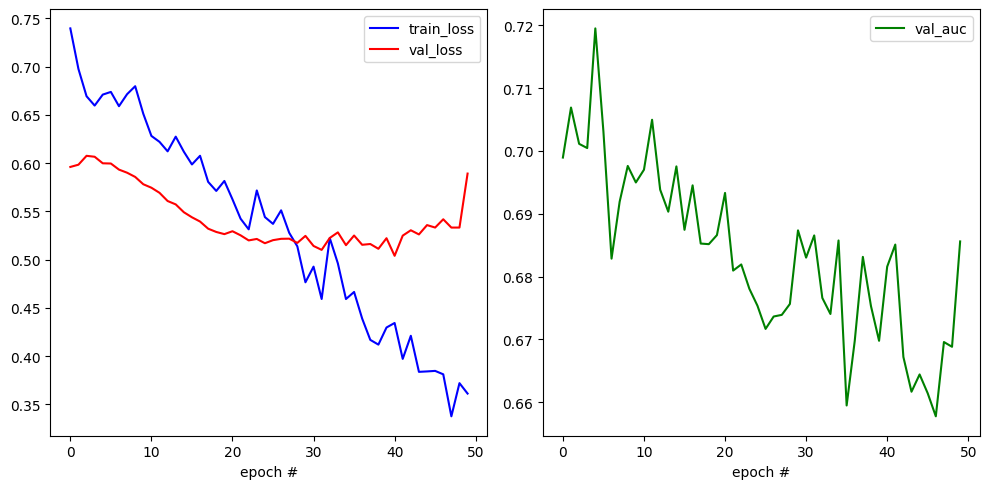


 ############################ CV-Fold 1 - Balanced training ############################

Init loss function... Done!

Init Model... Done!


100%|██████████| 43/43 [00:00<00:00, 115.75it/s]


Init optimizer ... Done!


EPOCH:   0    Train loss: 0.735    Val loss: 0.599    ROC_AUC: 0.518    Max AUC: 0.5178  -    AUC_1: 0.761  AUC_2: 0.387  AUC_3: 0.405
EPOCH:   1    Train loss: 0.700    Val loss: 0.603    ROC_AUC: 0.534    Max AUC: 0.5344  -    AUC_1: 0.741  AUC_2: 0.404  AUC_3: 0.458
EPOCH:   2    Train loss: 0.688    Val loss: 0.606    ROC_AUC: 0.540    Max AUC: 0.5400  -    AUC_1: 0.739  AUC_2: 0.398  AUC_3: 0.484
EPOCH:   3    Train loss: 0.667    Val loss: 0.611    ROC_AUC: 0.550    Max AUC: 0.5503  -    AUC_1: 0.736  AUC_2: 0.428  AUC_3: 0.487
EPOCH:   4    Train loss: 0.662    Val loss: 0.612    ROC_AUC: 0.545    Max AUC: 0.5503  -    AUC_1: 0.730  AUC_2: 0.424  AUC_3: 0.480
EPOCH:   5    Train loss: 0.659    Val loss: 0.611    ROC_AUC: 0.545    Max AUC: 0.5503  -    AUC_1: 0.722  AUC_2: 0.415  AUC_3: 0.497
EPOCH:   6    Train loss: 0.662    Val loss: 0.607    ROC_AUC: 0.532    Max AUC: 0.5503  -    AUC_1: 0.722  AUC_2: 0.380  AUC_3: 0.493
EPOCH:   7    Train loss: 0.637    Val loss: 0.605    R

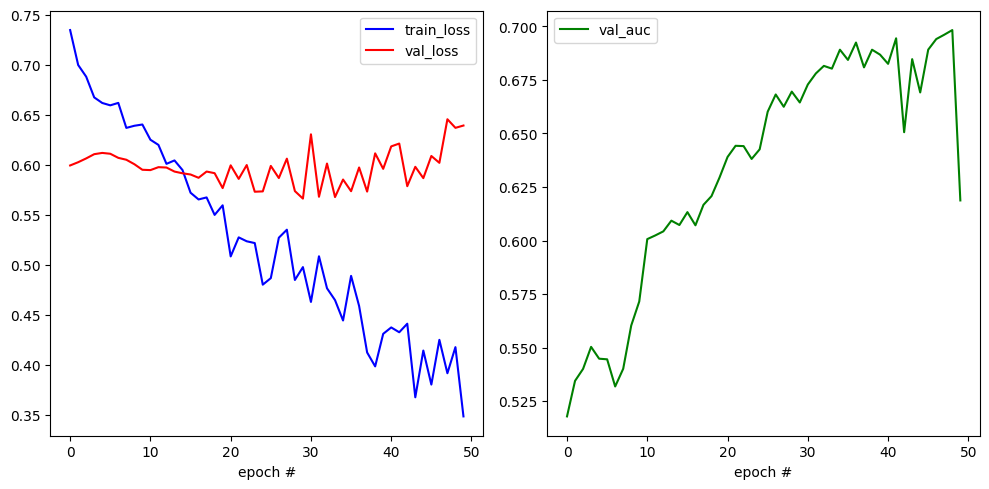


 ############################ CV-Fold 2 - Balanced training ############################

Init loss function... Done!

Init Model... Done!


100%|██████████| 43/43 [00:00<00:00, 103.35it/s]


Init optimizer ... Done!


EPOCH:   0    Train loss: 0.740    Val loss: 0.616    ROC_AUC: 0.493    Max AUC: 0.4933  -    AUC_1: 0.721  AUC_2: 0.331  AUC_3: 0.428
EPOCH:   1    Train loss: 0.703    Val loss: 0.615    ROC_AUC: 0.501    Max AUC: 0.5009  -    AUC_1: 0.728  AUC_2: 0.333  AUC_3: 0.441
EPOCH:   2    Train loss: 0.687    Val loss: 0.618    ROC_AUC: 0.535    Max AUC: 0.5348  -    AUC_1: 0.721  AUC_2: 0.413  AUC_3: 0.471
EPOCH:   3    Train loss: 0.669    Val loss: 0.619    ROC_AUC: 0.541    Max AUC: 0.5407  -    AUC_1: 0.721  AUC_2: 0.411  AUC_3: 0.490
EPOCH:   4    Train loss: 0.662    Val loss: 0.621    ROC_AUC: 0.545    Max AUC: 0.5450  -    AUC_1: 0.721  AUC_2: 0.418  AUC_3: 0.497
EPOCH:   5    Train loss: 0.657    Val loss: 0.620    ROC_AUC: 0.541    Max AUC: 0.5450  -    AUC_1: 0.705  AUC_2: 0.422  AUC_3: 0.497
EPOCH:   6    Train loss: 0.630    Val loss: 0.620    ROC_AUC: 0.531    Max AUC: 0.5450  -    AUC_1: 0.697  AUC_2: 0.403  AUC_3: 0.493
EPOCH:   7    Train loss: 0.647    Val loss: 0.618    R

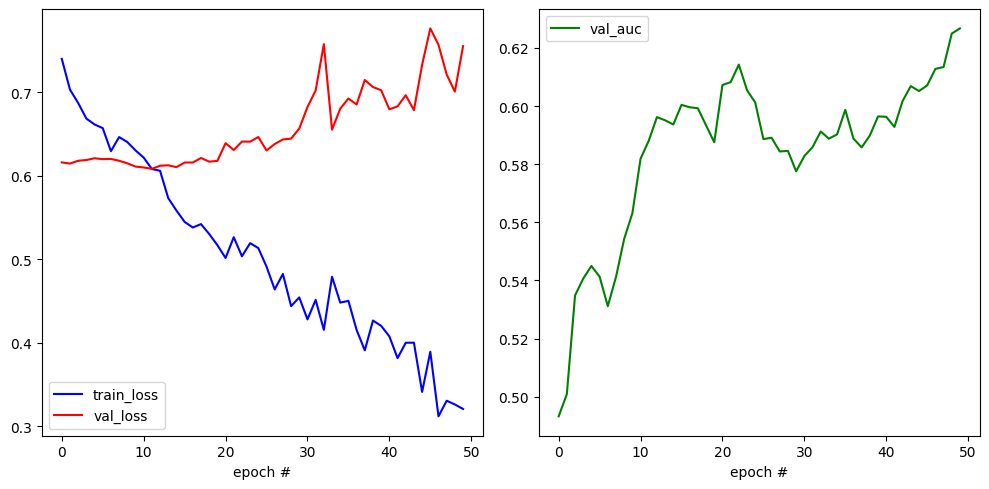


 ############################ CV-Fold 3 - Balanced training ############################

Init loss function... Done!

Init Model... Done!


100%|██████████| 43/43 [00:00<00:00, 151.01it/s]


Init optimizer ... Done!


EPOCH:   0    Train loss: 0.742    Val loss: 0.615    ROC_AUC: 0.543    Max AUC: 0.5432  -    AUC_1: 0.738  AUC_2: 0.303  AUC_3: 0.588
EPOCH:   1    Train loss: 0.709    Val loss: 0.614    ROC_AUC: 0.591    Max AUC: 0.5914  -    AUC_1: 0.726  AUC_2: 0.398  AUC_3: 0.650
EPOCH:   2    Train loss: 0.673    Val loss: 0.617    ROC_AUC: 0.581    Max AUC: 0.5914  -    AUC_1: 0.733  AUC_2: 0.368  AUC_3: 0.641
EPOCH:   3    Train loss: 0.678    Val loss: 0.617    ROC_AUC: 0.555    Max AUC: 0.5914  -    AUC_1: 0.726  AUC_2: 0.329  AUC_3: 0.611
EPOCH:   4    Train loss: 0.651    Val loss: 0.617    ROC_AUC: 0.553    Max AUC: 0.5914  -    AUC_1: 0.741  AUC_2: 0.316  AUC_3: 0.601
EPOCH:   5    Train loss: 0.671    Val loss: 0.615    ROC_AUC: 0.549    Max AUC: 0.5914  -    AUC_1: 0.741  AUC_2: 0.320  AUC_3: 0.585
EPOCH:   6    Train loss: 0.663    Val loss: 0.611    ROC_AUC: 0.545    Max AUC: 0.5914  -    AUC_1: 0.736  AUC_2: 0.329  AUC_3: 0.569
EPOCH:   7    Train loss: 0.656    Val loss: 0.612    R

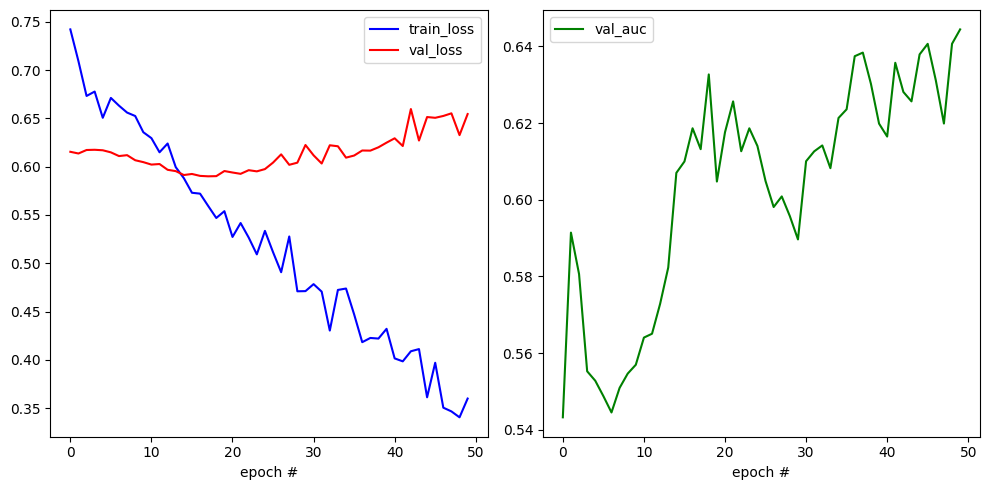


 ############################ CV-Fold 4 - Balanced training ############################

Init loss function... Done!

Init Model... Done!


100%|██████████| 42/42 [00:00<00:00, 123.71it/s]


Init optimizer ... Done!


EPOCH:   0    Train loss: 0.738    Val loss: 0.602    ROC_AUC: 0.669    Max AUC: 0.6690  -    AUC_1: 0.793  AUC_2: 0.431  AUC_3: 0.783
EPOCH:   1    Train loss: 0.707    Val loss: 0.603    ROC_AUC: 0.677    Max AUC: 0.6766  -    AUC_1: 0.841  AUC_2: 0.435  AUC_3: 0.754
EPOCH:   2    Train loss: 0.687    Val loss: 0.609    ROC_AUC: 0.688    Max AUC: 0.6880  -    AUC_1: 0.862  AUC_2: 0.444  AUC_3: 0.757
EPOCH:   3    Train loss: 0.675    Val loss: 0.609    ROC_AUC: 0.685    Max AUC: 0.6880  -    AUC_1: 0.873  AUC_2: 0.431  AUC_3: 0.750
EPOCH:   4    Train loss: 0.663    Val loss: 0.612    ROC_AUC: 0.681    Max AUC: 0.6880  -    AUC_1: 0.881  AUC_2: 0.404  AUC_3: 0.757
EPOCH:   5    Train loss: 0.667    Val loss: 0.608    ROC_AUC: 0.667    Max AUC: 0.6880  -    AUC_1: 0.870  AUC_2: 0.404  AUC_3: 0.728
EPOCH:   6    Train loss: 0.666    Val loss: 0.604    ROC_AUC: 0.677    Max AUC: 0.6880  -    AUC_1: 0.867  AUC_2: 0.429  AUC_3: 0.735
EPOCH:   7    Train loss: 0.647    Val loss: 0.601    R

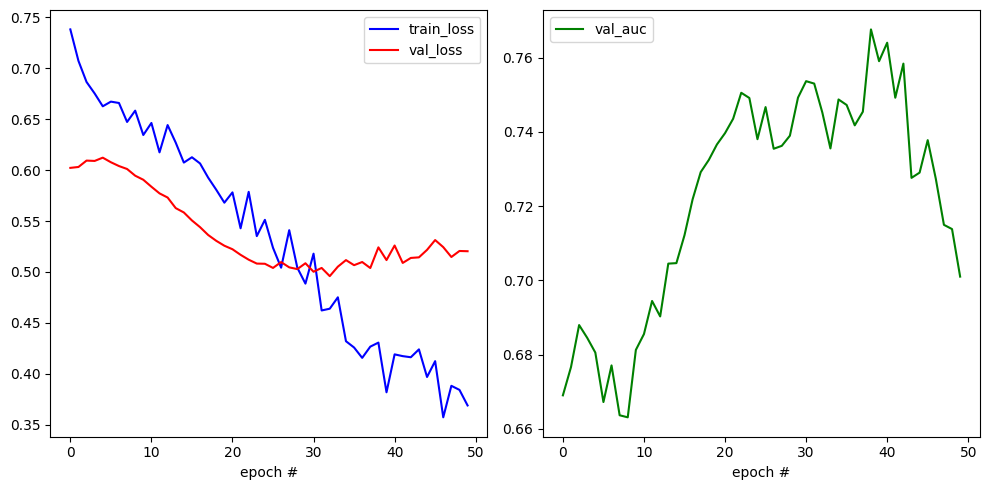

Max AUC in folds:  [np.float64(0.7195360195360196), np.float64(0.6982922791426628), np.float64(0.626742320859968), np.float64(0.6444139738257385), np.float64(0.7676578883837649)]
Mean AUC:  0.6913284963496308


In [21]:
for n_experiment in range(conf_train.n_experiment):

    print('\n')
    print('\n')
    print(f'##################################################################')
    print(f'###################### RUN - {n_experiment} ######################')
    print(f'##################################################################')
    print('\n')
    print('\n')
    max_val_aucs_all_epoch = []

    for i in range(5):

        print(f'\n ############################ CV-Fold {i} - Balanced training ############################')
        seed_torch(n_experiment)

        print('\nInit loss function...', end=' ')
        #loss_fn = nn.CrossEntropyLoss()

        # Use focal loss
        loss_fn = FocalLoss(gamma=1.0, alpha=alpha_mean_norm)
        
        print('Done!')

        print('\nInit Model...', end=' ')
        device = torch.device(f'cuda:{CUDA_NUM}' if torch.cuda.is_available() else 'cpu')
        model = Feature_attention( conf_train.emb_dim, 
                                   conf_train.hidden_dim, 
                                   conf_train.att_hidden_dim,
                                   conf_train.dropout_fc,
                                   conf_train.dropout_attn, 
                                   conf_train.n_classes).to(device)
        print('Done!')

        train_df = pd.read_csv(f'{conf_train["cv_split_dir"]}train_split_multi_stratified_{i}.csv')
        val_df = pd.read_csv(f'{conf_train["cv_split_dir"]}val_split_multi_stratified_{i}.csv')

        X_train_all, y_train_all = read_cv_data(train_df)
        X_val_all, y_val_all = read_cv_data(val_df)
        
        #print(np.unique(y_train_all))
        #print(np.unique(y_val_all))

        results_dir = conf_train.results_dir + f'experiment_{n_experiment}/'
        #print("Results dir: ", results_dir)
        os.makedirs(results_dir, exist_ok=True)
        OmegaConf.save(config=OmegaConf.create(conf_train), f=results_dir+"conf_train.yaml")

        num_epochs = conf_train.num_epochs
        batch_size = conf_train.batch_size
        n_classes = conf_train.n_classes
        
        param_dict = train_loop(i, X_train_all, y_train_all, X_val_all, y_val_all, 
                                results_dir, num_epochs, model, n_classes, loss_fn, gc=32)
        
        max_val_aucs_all_epoch.append( np.max(param_dict['val_auc_all_epoch']) )


        json_data = {'num_epochs': param_dict['num_epochs'],
                     'train_loss_all_epoch_cv': param_dict['train_loss_all_epoch'],
                     'val_loss_all_epoch_all_cv': param_dict['val_loss_all_epoch'],
                     'val_auc_all_epoch_all_cv': param_dict['val_auc_all_epoch'],
                     'min_val_loss': np.min(param_dict['val_loss_all_epoch']),
                     'max_val_auc': np.max(param_dict['val_auc_all_epoch'])}

        # Save training parameters to disk    
        with open(results_dir + f"cv_{i}/" 'test_params.json', 'w') as file:
            json.dump(json_data, file)

        """    
        # plot curves
        plt.figure(figsize=(6,6))
        plt.plot(json_data['train_loss_all_epoch_cv'], "-b", label="train_loss")
        plt.plot(json_data['val_loss_all_epoch_all_cv'], "-r", label="val_loss")
        plt.legend(loc="upper right")

        plt.figure(figsize=(6,6))
        plt.plot(json_data['val_auc_all_epoch_all_cv'], "-g", label="val_auc")
        plt.legend(loc="upper right")
        """
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

        ax1.plot(json_data['train_loss_all_epoch_cv'], "-b", label="train_loss")
        ax1.plot(json_data['val_loss_all_epoch_all_cv'], "-r", label="val_loss")
        ax1.set_xlabel('epoch #')
        ax1.legend()

        ax2.plot(json_data['val_auc_all_epoch_all_cv'], "-g", label="val_auc")
        ax2.set_xlabel('epoch #')
        ax2.legend()

        plt.tight_layout()
        plt.show()
        
        
        # free memory !
        del X_train_all, y_train_all, X_val_all, y_val_all

    print('Max AUC in folds: ', max_val_aucs_all_epoch)
    print('Mean AUC: ', np.mean(max_val_aucs_all_epoch))

In [22]:
max_val_aucs_all_epoch

[np.float64(0.7195360195360196),
 np.float64(0.6982922791426628),
 np.float64(0.626742320859968),
 np.float64(0.6444139738257385),
 np.float64(0.7676578883837649)]

In [23]:
np.mean(max_val_aucs_all_epoch)

np.float64(0.6913284963496308)